# **Deep learning for image analysis with Python**

#### Fernando Cervantes, Systems Analyst I, Imaging Solutions, Research IT
#### fernando.cervantes@jax.org    (slack) @fernando.cervantes

## **3 Implement a deep neural network**

## 3.1 _Neural network modules_

PyTorch provides several operations that can be used as building blocks to construct a neural network.<br>
Each operation is commonly referred as a **Module**, and those are implemented inside the *nn* module of pytorch.

In [5]:
import torch
import torch.nn as nn

![Image](https://pytorch.org/tutorials/_images/mnist.png)

### 3.1.1 What are convolutions

First, images can be considered as functions. In the case of two dimensions an image is a function $F: (x, y) \mapsto I$, where $x, y \in \mathbb{R}$, and $I \in \mathbb{R}^3$, for RGB images, or $I \in \mathbb{R}$ for grayscale images.<br>
Second, image functions can be _digitized_ into a digital signal that can be stored in a computer.<br>

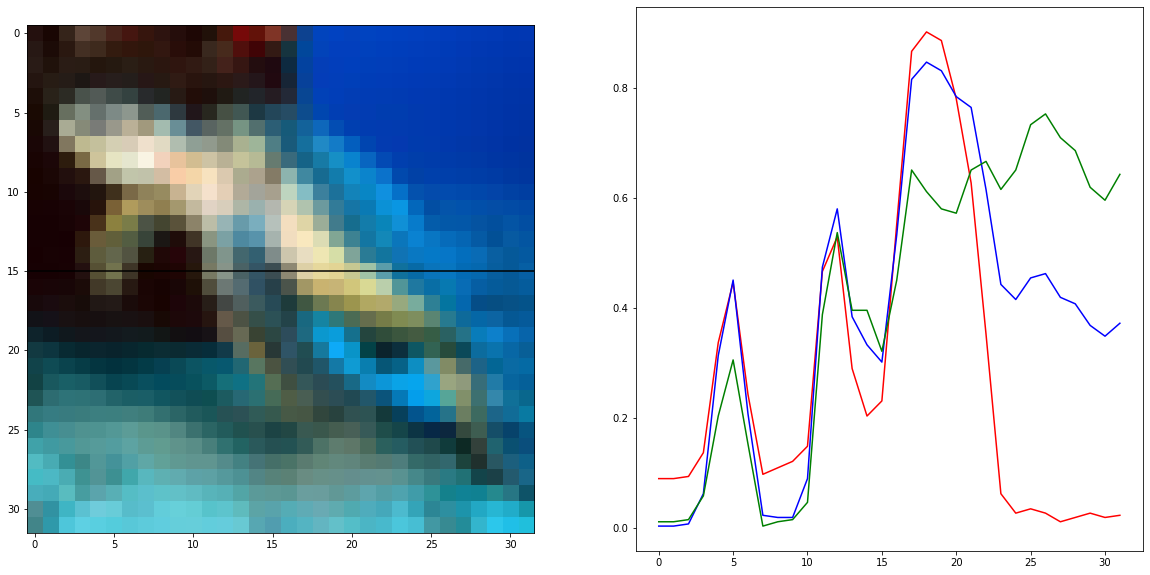

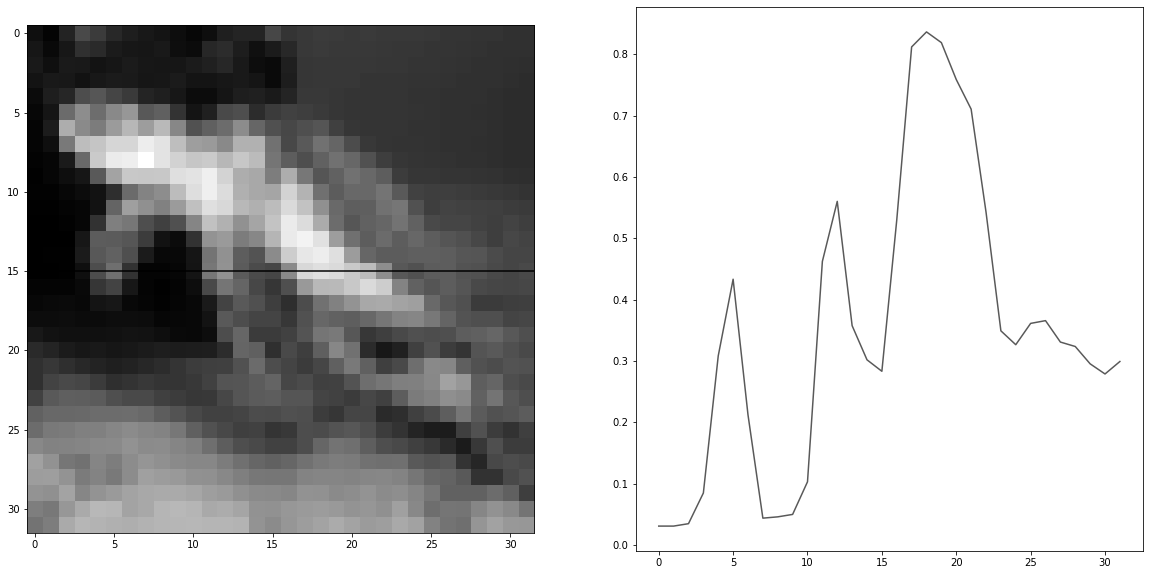

In [44]:
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

cifar_trn_dataset = CIFAR100(root=r'C:\Users\cervaf\Documents\Datasets', download=False, train=True, transform=ToTensor())
x, t = cifar_trn_dataset[99]

plt.rcParams['figure.figsize'] = [20, 10]

plt.subplot(1, 2, 1)
plt.imshow(x.permute(1, 2, 0))
plt.plot([-0.5, 31.5], [15, 15], "k")
plt.subplot(1, 2, 2)
plt.plot(x[0, 15, :], "r")
plt.plot(x[1, 15, :], "b")
plt.plot(x[2, 15, :], "g")
plt.show()

x_gray = torch.sum( torch.FloatTensor([[[0.2989]], [[0.5870]], [[0.1140]]]) * x, dim=0)

plt.subplot(1, 2, 1)
plt.imshow(x_gray, cmap='gray')
plt.plot([-0.5, 31.5], [15, 15], "k")
plt.subplot(1, 2, 2)
plt.plot(x_gray[15, :], c='0.35')
plt.show()

Convolutions are linear transforms that can be applied to a function. This linear transform computes the inner product between two functions (the input and a kernel) over the input domain.<br>
When applied to digital (discrete) signals, the inner product is changed by a linear combination (sum). <br>
### $R(x, y) = \sum\limits_{x, y}\sum\limits_{u, v} I(x-u, y-v) * k(u,v)$ <br>
Lets see a convolution using a _kernel_ of size 3$\times$3 in action!

In [76]:
kernel = torch.FloatTensor([[[
    [0, 1, 0], 
    [0, 0, 0], 
    [0, -1, 0]
]]])

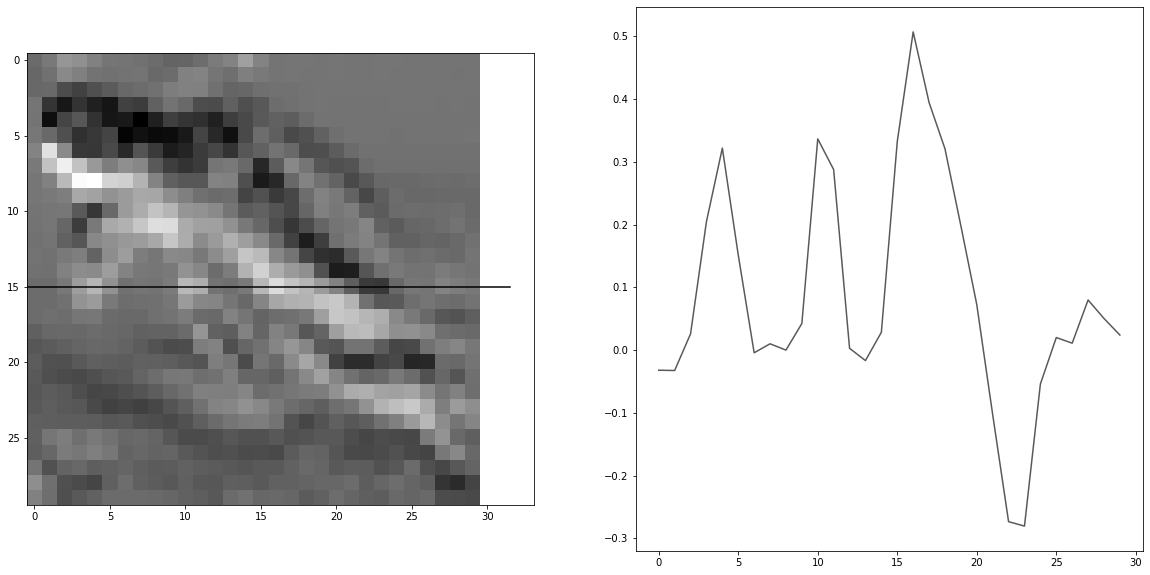

In [77]:
import torch.nn.functional as F

res = F.conv2d(x_gray.view(1, 1, 32, 32), kernel).squeeze()

plt.subplot(1, 2, 1)
plt.imshow(res, cmap='gray')
plt.plot([-0.5, 31.5], [15, 15], "k")
plt.subplot(1, 2, 2)
plt.plot(res[15, :], c='0.35')
plt.show()

More on filters and convolutions can be found [here](https://petebankhead.gitbooks.io/imagej-intro/content/chapters/filters/filters.html#sec-filters_linear_general).


![Image](https://pytorch.org/tutorials/_images/mnist.png)

The first layer applies **six** $5\times5$ linear kernels over every pixel of the input image.<br>

In [66]:
conv_1 = nn.Conv2d(
    in_channels=1, # Because the input image is in gray-levels
    out_channels=6, # to generate six new feature maps / channels
    kernel_size=5,
    stride=1, # to pass the kernel filters over each pixel of the image
    padding=0, # do not add padding to the image edges (this will reduce the size of the output)
    bias=False # do not add a bias intercept to the output of this layer
)

In [67]:
conv_1 = nn.Conv2d(
    in_channels=1, # Because the input image is in gray-levels
    out_channels=6, # to generate six new feature maps / channels
    kernel_size=5
)

_More details of the available parameters to create a two dimensional convolutional layer can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d)_

In [68]:
conv_1

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))

In [69]:
print(conv_1.weight.size())
print(conv_1.weight)

torch.Size([6, 1, 5, 5])
Parameter containing:
tensor([[[[-0.0397, -0.1049,  0.0119,  0.0219, -0.1862],
          [ 0.1680,  0.1961,  0.1294, -0.0408, -0.0831],
          [-0.1783,  0.1281,  0.0618, -0.0044,  0.1295],
          [ 0.0050, -0.0533, -0.0355,  0.0872,  0.1167],
          [ 0.0602,  0.0234, -0.0816, -0.0471,  0.0305]]],


        [[[-0.1206, -0.1521, -0.1763,  0.0750,  0.1771],
          [-0.0384,  0.1653,  0.0063,  0.1898,  0.0884],
          [-0.0258, -0.1689,  0.1008, -0.0592, -0.1958],
          [-0.1553,  0.0791, -0.1597, -0.1614,  0.0376],
          [ 0.0050,  0.1458,  0.1256,  0.1286,  0.1394]]],


        [[[-0.1259,  0.0033, -0.0513, -0.1690, -0.1482],
          [-0.1011,  0.1539, -0.1589,  0.1759,  0.1547],
          [ 0.0046,  0.1494, -0.1892,  0.1140,  0.0651],
          [ 0.0534, -0.1390,  0.0561, -0.0622,  0.0087],
          [-0.0031, -0.1470,  0.0575,  0.1949,  0.1915]]],


        [[[-0.1469,  0.1468,  0.1521, -0.1207, -0.1289],
          [ 0.1870, -0.0116, 

Because we defined *conv_1* using a **nn.Module**, the operation will track the gradients for the weights and bias of that operation.<br>
Those weights and bias are kwnown as the *learnable parameters*.<br>
By default, bias is always added to linear and convolution operations.<br>
This single layer has $6\times1\times5\times 5 = 150$ parameters.

***
The following operation applied to the first convolution layer is a ReLU activation function.<br>
These functions can be found also inside the PyTorch's *nn* module (follow this [link](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) to see the different activation functions available).

In [9]:
act_1 = nn.ReLU()

In [10]:
act_1

ReLU()

***
The subsampling operation (S2 in the LeNet's illustration) is implemented by a *max pooling* operation.

In [11]:
sub_1 = nn.MaxPool2d(
    kernel_size=2,
    stride=2,
    padding=0
)

In [11]:
sub_1 = nn.MaxPool2d(
    kernel_size=2,
    stride=2
)

In [12]:
sub_1

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

***
Depending the task, the last layers of a network will be used to abstract the spatial information into a one-dimensional representation.
This is achieved by *flattening* the tensor into a *vector*, to perform linear operations (matrix-vector).
These layers are known as **Fully Connected** (FC), and are implemented by multilayer perceptrons.

In [15]:
fc_1 = nn.Linear(
    in_features=16*5*5, 
    out_features=120, 
    bias=True
)

In [16]:
fc_1

Linear(in_features=400, out_features=120, bias=True)

***
## 3.2 _Neural network inputs_

PyTorch modules expect the inputs to be in the shape of *batch size* $\times$ *input channels* $\times$ *height* $\times$ *width* 

In [93]:
x = torch.rand((1, 1, 32, 32))

Modules defined from the *nn* module have a built-in *forward* function.
The default behavior of nn modules when called is to use their correspondig *forward* function.

In [94]:
fx = conv_1(x)

In [95]:
fx.size()

torch.Size([1, 6, 28, 28])

In the LeNet's architecture illustration, the output of the first convolution layer (C1) are six feature maps of size $28\times28$.

![Image](https://pytorch.org/tutorials/_images/mnist.png)

***
The next operation is a ReLU activation function that is applied element-wise to each element of the tensor.

In [21]:
fx = act_1(fx)

In [22]:
fx.size()

torch.Size([1, 6, 28, 28])

***
The subsampling operation is applied using a kernel of size $2\times2$, and is applied every $2$ pixels, resulting on a feature map with half the size of the input tensor.

In [24]:
fx = sub_1(fx)

In [25]:
fx.size()

torch.Size([1, 6, 14, 14])

Now, the feature maps have a size of $14\times14$, just as illustrated in the LeNet's architecture.

***

## 3.3 _Defining a neural network architecture as a python class_

PyTorch provides a *pythonic* framework to develop neural networks.
For that reason, architectures are defined as classes derived from the **nn.Module** class.<br>
A class defining an neural network architecture is rquired to call the nn.Module initialization function and implement a **forward** function.

![Image](https://pytorch.org/tutorials/_images/mnist.png)

Fully connected layers are a fancy name for Multilayer perceptrons

In [150]:
class LeNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        """
        Always call the initialization function from the nn.Module parent class.
        This way all parameters from the operations defined as members of *this* class are tracked for their optimization.
        """
        super(LeNet, self).__init__()
        
        self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.sub_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv_2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.sub_2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc_1 = nn.Linear(in_features=5*5*16, out_features=120)
        self.fc_2 = nn.Linear(in_features=120, out_features=84)
        self.fc_3 = nn.Linear(in_features=84, out_features=num_classes)
        
        self.act_fn = nn.ReLU()

    def forward(self, x):
        # Apply convolution layers to extract feature maps with image context
        fx = self.act_fn(self.conv_1(x))
        fx = self.sub_1(fx)
        
        fx = self.act_fn(self.conv_2(fx))
        fx = self.sub_2(fx)
        
        # Flatten the feature maps to perform linear operations
        fx = fx.view(-1, 16*5*5)
        
        fx = self.act_fn(self.fc_1(fx))
        fx = self.act_fn(self.fc_2(fx))
        y = self.fc_3(fx)
        
        return y

In [151]:
net = LeNet(1, 10)

In [152]:
print(net)

LeNet(
  (conv_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (sub_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (sub_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
  (act_fn): ReLU()
)


In [153]:
print(x.size())

torch.Size([1, 1, 32, 32])


In [154]:
y = net(x)

In [155]:
print(y.size())

torch.Size([1, 10])


In [156]:
print(y)

tensor([[-0.0838, -0.1127, -0.1032,  0.0788, -0.1010, -0.0274, -0.0827, -0.0623,
          0.1434, -0.0615]], grad_fn=<AddmmBackward0>)


In [157]:
print(y.softmax(dim=1))

tensor([[0.0955, 0.0928, 0.0937, 0.1124, 0.0939, 0.1010, 0.0956, 0.0976, 0.1199,
         0.0977]], grad_fn=<SoftmaxBackward0>)


In [158]:
print(y.softmax(dim=1).sum(dim=1))

tensor([1.], grad_fn=<SumBackward1>)


In [159]:
total_parameters = 0
for par in net.parameters():
    total_parameters += torch.numel(par)

In [160]:
total_parameters

61706